# 114th Congress Data

This notebook is meant to call, clean, and examine data from the 2014 election, to produce a viable metric correlating PVI and electoral success.

It feeds into a larger project about fairness in redistricting; for instance, if an R+15 district is unattainable for a Democrat to win, then the district can be wholly classified as "safe," and should be bucketed with R+30 district.

The nuance enters in the margins. How safe is an R+6 district for instance? Can we quantify a district moving from R+3 to R+6 as a significant bias against Democrats? By cleaning this dataset, and others like it, we can determine the predictive power of PVI in each district, and use those probabilities later to assess redistricting fairness.

## Retrieve data from Wikipedia

Wikipedia's current Cook PVI page contains a free and current (up to 2020 election results) version of the index, where free downloads from Cook's website are dated, containing 2018 results and 2016 PVI metrics

In [1]:
import requests
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#import and format url
url = "https://web.archive.org/web/20160807095451/https://en.wikipedia.org/wiki/Cook_partisan_voting_index"
page = pd.read_html(url)
dat = pd.concat(page,ignore_index=True)

In [3]:
#split data into state and district pvis
wiki_district = dat[5:440]
wiki_state = dat[446:]

In [4]:
#cut NA columns
wiki_district = wiki_district.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
wiki_state = wiki_state.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

## Clean and Organize State Data

In [5]:
#call in a dictionary of state abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [6]:
state_114 = wiki_state
state_114["ST"] =  state_114["State"]
#abbreviate the ST coulmn
state_114 = state_114.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(state_114["ST"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [7]:
#split out pvi by party and weight
#first eliminate even values
state_114["PVI"] = state_114["PVI"].str.replace("EVEN","R+0")
state_114["pvi_party"] = state_114.PVI.str[0]
state_114['partisan_weight'] = state_114['PVI'].str.split('+').str[1]
#check results
print(state_114.head(n=1))
print(state_114["pvi_party"].unique())

    House balance   PVI Party in Senate Party of Governor    State  ST  \
446        6R, 1D  R+14      Republican        Republican  Alabama  AL   

    pvi_party partisan_weight  
446         R              14  
['R' 'D']


In [8]:
#add constants for later aggregation
state_114["year"] = 2014
state_114["congress"] = 114

In [9]:
#create a variable that is negative when the party is democratic
state_114["neg"] = state_114['pvi_party'].str.replace('D','-')
state_114["neg"] = state_114["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
state_114['partisan_weight'] = state_114["neg"] + state_114['partisan_weight']
#ensure values are integers
state_114['partisan_weight'] = state_114['partisan_weight'].astype(int)

In [10]:
state_114["metric"] = ((state_114['partisan_weight'] / 2) + 50) / 100
state_114.head(n=7)

,House balance,PVI,Party in Senate,Party of Governor,State,ST,pvi_party,partisan_weight,year,congress,neg,metric
446,"6R, 1D",R+14,Republican,Republican,Alabama,AL,R,14,2014,114,,0.570
447,1R,R+12,Republican,Independent,Alaska,AK,R,12,2014,114,,0.560
448,"5R, 4D",R+7,Republican,Republican,Arizona,AZ,R,7,2014,114,,0.535
449,4R,R+14,Republican,Republican,Arkansas,AR,R,14,2014,114,,0.570
450,"39D, 14R",D+9,Democratic,Democratic,California,CA,D,-9,2014,114,-,0.455
451,"4R, 3D",D+1,Both,Democratic,Colorado,CO,D,-1,2014,114,-,0.495
452,5D,D+7,Democratic,Democratic,Connecticut,CT,D,-7,2014,114,-,0.465


In [11]:
state_114 = state_114[["year","ST","PVI","metric"]]
state_114.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_114.csv",index=False)

In [12]:
state_114.head(8)

,year,ST,PVI,metric
446,2014,AL,R+14,0.570
447,2014,AK,R+12,0.560
448,2014,AZ,R+7,0.535
449,2014,AR,R+14,0.570
450,2014,CA,D+9,0.455
451,2014,CO,D+1,0.495
452,2014,CT,D+7,0.465
453,2014,DE,D+8,0.460


## Clean and Organize the District Data

In [13]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

In [14]:
#load in and check the data
pvi_114 = wiki_district
print(pvi_114.head(n=1))
print(pvi_114.shape)

  District   PVI Party of Representative    State
5      1st  R+15              Republican  Alabama
(435, 4)


In [15]:
#correct the column name for later use
pvi_114 = pvi_114.rename(columns={"Party of Representative": "Representative"})

In [16]:
#fix at large designation
pvi_114['District'] = pvi_114['District'].str.replace('At-large','AL')
pvi_114['District'] = pvi_114['District'].str.rstrip("st")
pvi_114['District'] = pvi_114['District'].str.rstrip("nd")
pvi_114['District'] = pvi_114['District'].str.rstrip("rd")
pvi_114['District'] = pvi_114['District'].str.rstrip("th")
pvi_114.head(n=8)

,District,PVI,Representative,State
5,1,R+15,Republican,Alabama
6,2,R+17,Republican,Alabama
7,3,R+16,Republican,Alabama
8,4,R+28,Republican,Alabama
9,5,R+17,Republican,Alabama
10,6,R+28,Republican,Alabama
11,7,D+20,Democratic,Alabama
12,AL,R+12,Republican,Alaska


In [17]:
#seperate state and district
pvi_114["num"] = pvi_114.District
pvi_114["ST"] =  pvi_114["State"]
pvi_114.head(n=1)

,District,PVI,Representative,State,num,ST
5,1,R+15,Republican,Alabama,1,Alabama


In [18]:
#abbreviate the ST coulmn
pvi_114 = pvi_114.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(pvi_114["ST"].unique())
print(pvi_114["num"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
['1' '2' '3' '4' '5' '6' '7' 'AL' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53']


In [19]:
#create the district code variable
pvi_114["ST#"] = pvi_114["ST"] + pvi_114["num"]
#create the "party of represenative" variable
pvi_114["seat"] = pvi_114.Representative.str[0]
#make a dummy
pvi_114["is_GOP"] = pvi_114["seat"].replace("R",1)
pvi_114["is_GOP"] = pvi_114["is_GOP"].replace("D",0)
#The seats of Charlie Dent and Pat Meehan in Pennsylvania went R -> D during this time frame
#covert to integer for later numeric analysis
pvi_114["is_GOP"] = pvi_114["is_GOP"].astype(int)
pvi_114.head(n=7)
print(pvi_114["is_GOP"].unique())

[1 0]


In [20]:
#possibly unneccessary
#pull out district lean
pvi_114["lean"] = pvi_114.PVI.str[0]
pvi_114["lean"].unique()

array(['R', 'D', 'E'], dtype=object)

In [21]:
#split out pvi by party and weight
#first eliminate even values
pvi_114["PVI"] = pvi_114["PVI"].str.replace("EVEN","R+0")
pvi_114["pvi_party"] = pvi_114.PVI.str[0]
pvi_114['partisan_weight'] = pvi_114['PVI'].str.split('+').str[1]
#check results
print(pvi_114.head(n=1))
print(pvi_114["pvi_party"].unique())

  District   PVI Representative    State num  ST  ST# seat  is_GOP lean  \
5        1  R+15     Republican  Alabama   1  AL  AL1    R       1    R   

  pvi_party partisan_weight  
5         R              15  
['R' 'D']


In [22]:
#create a variable that is negative when the party is democratic
pvi_114["neg"] = pvi_114['pvi_party'].str.replace('D','-')
pvi_114["neg"] = pvi_114["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
pvi_114['partisan_weight'] = pvi_114["neg"] + pvi_114['partisan_weight']
#ensure values are integers
pvi_114['partisan_weight'] = pvi_114['partisan_weight'].astype(int)

In [23]:
pvi_114["metric"] = ((pvi_114['partisan_weight'] / 2) + 50) / 100
pvi_114.head(n=7)

,District,PVI,Representative,State,num,ST,ST#,seat,is_GOP,lean,pvi_party,partisan_weight,neg,metric
5,1,R+15,Republican,Alabama,1,AL,AL1,R,1,R,R,15,,0.575
6,2,R+17,Republican,Alabama,2,AL,AL2,R,1,R,R,17,,0.585
7,3,R+16,Republican,Alabama,3,AL,AL3,R,1,R,R,16,,0.580
8,4,R+28,Republican,Alabama,4,AL,AL4,R,1,R,R,28,,0.640
9,5,R+17,Republican,Alabama,5,AL,AL5,R,1,R,R,17,,0.585
10,6,R+28,Republican,Alabama,6,AL,AL6,R,1,R,R,28,,0.640
11,7,D+20,Democratic,Alabama,7,AL,AL7,D,0,D,D,-20,-,0.400


In [24]:
#add constants for later aggregation
pvi_114["year"] = 2014
pvi_114["congress"] = 114

## Export clean versions of the data

In [25]:
#create a dataset solely to correlate pvi with the holder of the seat
pure_114 = pvi_114[["year","metric","is_GOP"]]
pure_114.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/pure_datasets/pure_114.csv",index=False)
#create a more detailed dataset for greater uses
data_114 = pvi_114[["year","congress","ST","ST#","seat","is_GOP","PVI","metric"]]
data_114.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_114.csv",index=False)

In [26]:
data_114.head(8)

,year,congress,ST,ST#,seat,is_GOP,PVI,metric
5,2014,114,AL,AL1,R,1,R+15,0.575
6,2014,114,AL,AL2,R,1,R+17,0.585
7,2014,114,AL,AL3,R,1,R+16,0.580
8,2014,114,AL,AL4,R,1,R+28,0.640
9,2014,114,AL,AL5,R,1,R+17,0.585
10,2014,114,AL,AL6,R,1,R+28,0.640
11,2014,114,AL,AL7,D,0,D+20,0.400
12,2014,114,AK,AKAL,R,1,R+12,0.560


## Conduct preliminary examinations of the data

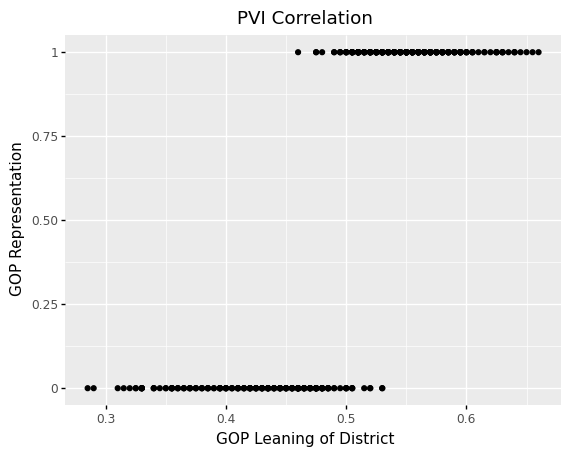

<ggplot: (8790468628809)>

In [27]:
# Create a super simple scatterplot to examine the relationship between PVI and congressional district
(p9.ggplot(data=pure_114, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y='GOP Representation',color="",title="PVI Correlation"))

From the 114th Congress, we can see that generally PVI is a perfect predictor of race outcome, except within the range of approximatley D+10 to R+10. 

In [28]:
#group by metric and average GOP seats
bm_114 = pure_114.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_114 = bm_114.reset_index()

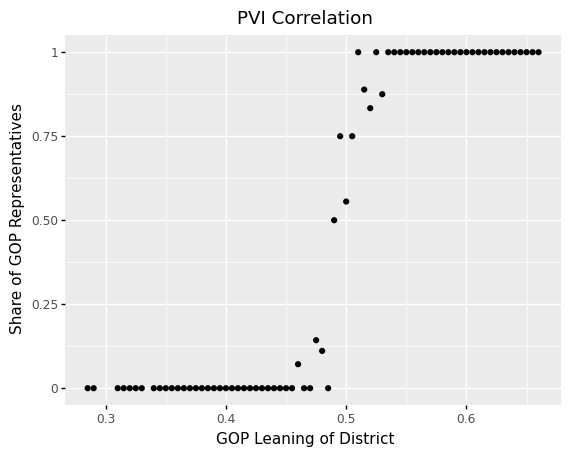

<ggplot: (8790472193037)>

In [29]:
#Plot averages
(p9.ggplot(data=bm_114, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

This data appears to be more of an even distribution; some Dem seats are GOP occupied and vice versa, but not with substantial bias; the close intersection of the regression line below with .5,.5 indicates a fairly predictable result

In [30]:
#now lets limit the data to only the R+10 to D+10 range, calling it Limited Domain
ld_114 = bm_114[bm_114["metric"] <= .55]
ld_114 = ld_114[ld_114["metric"] >= .45]

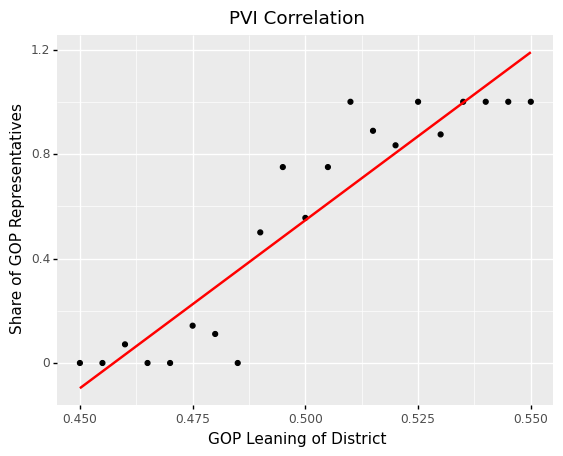

<ggplot: (8790472522924)>

In [31]:
#Plot averages
(p9.ggplot(data=ld_114, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + geom_smooth(method = "lm", color = "red", se = False)
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))